In [156]:
!pip install -q sentence-transformers xgboost scikit-learn matplotlib seaborn joblib

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import joblib

In [158]:
df = pd.read_csv("Think_Do_Contradiction_Dataset_Improved.csv")

In [159]:
# STEP 3: Initialize sentence transformer model
embedder = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Encode Intention and Action separately
intention_embeddings = embedder.encode(df["Intention"].astype(str).tolist(), show_progress_bar=True)
action_embeddings = embedder.encode(df["Action"].astype(str).tolist(), show_progress_bar=True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [160]:
# STEP 4: Combine features:
# Use concatenation plus cosine similarity as extra feature
cos_sim = np.array([cosine_similarity([i], [a])[0] for i, a in zip(intention_embeddings, action_embeddings)]).reshape(-1,1)

# Concatenate intention, action embeddings and cosine similarity feature
X = np.hstack([intention_embeddings, action_embeddings, cos_sim])

# Labels
y = df["Label"].values

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
# STEP 6: Define your models with class_weight='balanced' where supported
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=1, random_state=42),  # scale_pos_weight=1 for balanced
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}


===== Logistic Regression =====
              precision    recall  f1-score   support

       Align       0.98      1.00      0.99       111
  Contradict       1.00      0.98      0.99        89

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



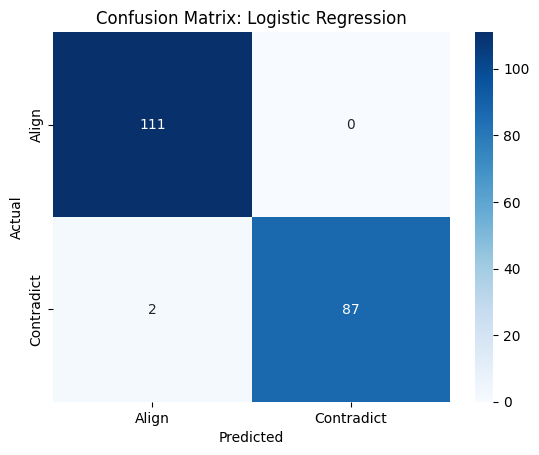


===== Random Forest =====
              precision    recall  f1-score   support

       Align       1.00      1.00      1.00       111
  Contradict       1.00      1.00      1.00        89

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



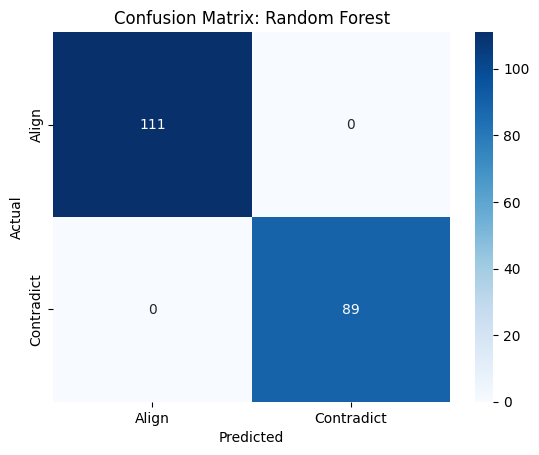


===== XGBoost =====
              precision    recall  f1-score   support

       Align       1.00      0.97      0.99       111
  Contradict       0.97      1.00      0.98        89

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200



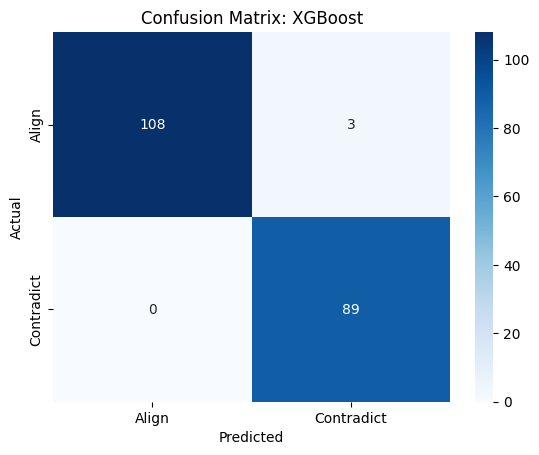


===== MLP Classifier =====
              precision    recall  f1-score   support

       Align       1.00      1.00      1.00       111
  Contradict       1.00      1.00      1.00        89

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



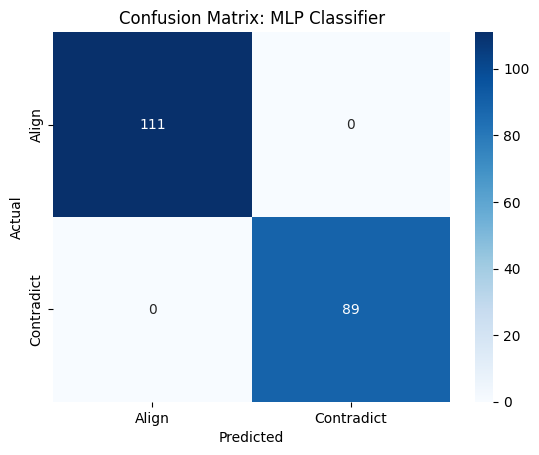

In [163]:
# STEP 7: Train, predict and evaluate all models
metrics_summary = []
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["Align", "Contradict"]))

    # Metrics for summary
    metrics_summary.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted')
    ])

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Align", "Contradict"], yticklabels=["Align", "Contradict"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

In [164]:
# STEP 8: Metrics summary table
metrics_df = pd.DataFrame(metrics_summary, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\n=== Metrics Summary Table ===")
print(metrics_df)


=== Metrics Summary Table ===
                 Model  Accuracy  Precision  Recall        F1
0  Logistic Regression     0.990   0.990177   0.990  0.989988
1        Random Forest     1.000   1.000000   1.000  1.000000
2              XGBoost     0.985   0.985489   0.985  0.985022
3       MLP Classifier     1.000   1.000000   1.000  1.000000



=== XGBoost Feature Importances ===


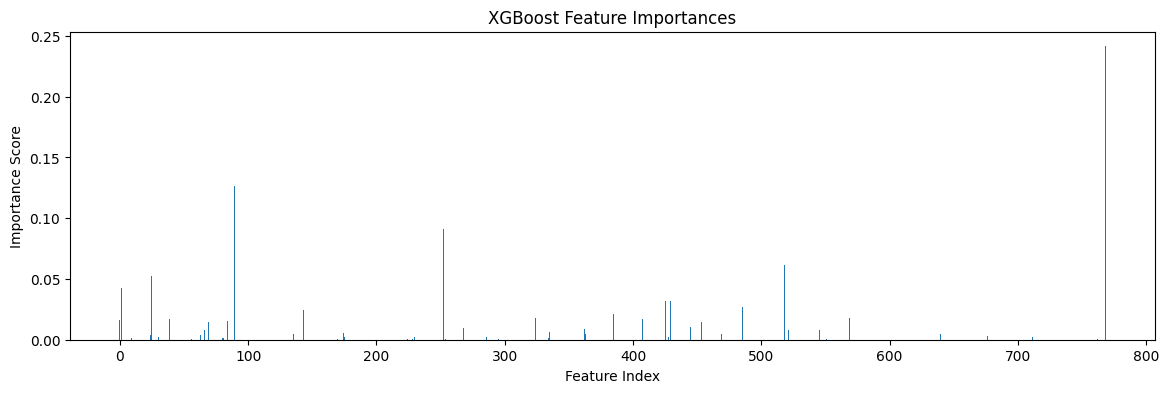

In [165]:
# STEP 9: Feature importance for XGBoost
print("\n=== XGBoost Feature Importances ===")
xgb_model = models["XGBoost"]
importances = xgb_model.feature_importances_
plt.figure(figsize=(14,4))
plt.bar(range(len(importances)), importances)
plt.title("XGBoost Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

In [166]:
# STEP 10: Error Analysis – print some misclassified examples (XGBoost)
y_pred_xgb = xgb_model.predict(X_test)
misclassified_idx = np.where(y_pred_xgb != y_test)[0]
print("\n=== Error Analysis: Some misclassified examples (XGBoost) ===")
for idx in misclassified_idx[:10]:
    original_idx = y_test.index[idx] if hasattr(y_test, 'index') else idx
    print("Intention:", df.iloc[original_idx]["Intention"])
    print("Action:", df.iloc[original_idx]["Action"])
    print("True Label:", "Align" if y_test[idx]==0 else "Contradict")
    print("Predicted:", "Align" if y_pred_xgb[idx]==0 else "Contradict")
    print("---")


=== Error Analysis: Some misclassified examples (XGBoost) ===
Intention: I will complete task16.
Action: I completed task16.
True Label: Align
Predicted: Contradict
---
Intention: I will complete task34.
Action: I did not complete task34.
True Label: Align
Predicted: Contradict
---
Intention: I won’t complete task24.
Action: I did not complete task24.
True Label: Align
Predicted: Contradict
---


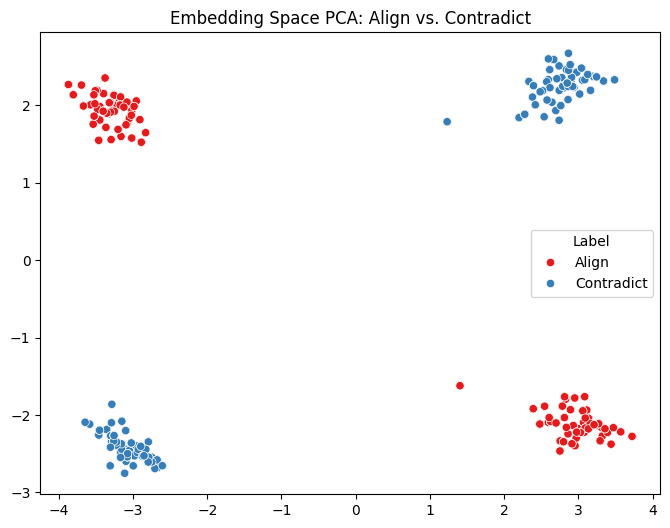

In [167]:
# STEP 11: Visualize Embeddings (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Label"].map({0:"Align",1:"Contradict"}), palette="Set1")
plt.title("Embedding Space PCA: Align vs. Contradict")
plt.show()

In [168]:
# STEP 12: Save best model (XGBoost)
joblib.dump(xgb_model, "xgb_model.pkl")
print("Saved XGBoost model as xgb_model.pkl")

Saved XGBoost model as xgb_model.pkl


In [169]:
# STEP 4: Train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_aug, y_train)
    y_pred = model.predict(X_test_aug)
    print(classification_report(y_test, y_pred, target_names=["Align", "Contradict"]))


===== Logistic Regression =====
              precision    recall  f1-score   support

       Align       0.91      0.81      0.86       111
  Contradict       0.79      0.90      0.84        89

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200


===== Random Forest =====
              precision    recall  f1-score   support

       Align       0.98      0.99      0.99       111
  Contradict       0.99      0.98      0.98        89

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200


===== XGBoost =====
              precision    recall  f1-score   support

       Align       0.98      0.99      0.99       111
  Contradict       0.99      0.98      0.98        89

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98    

In [170]:
# Kill all ngrok processes (and Streamlit if needed)
!pkill ngrok
!pkill streamlit
!fuser -k 8501/tcp || true


8501/tcp:            41176


In [171]:
# Install required packages quietly
!pip install -q streamlit pyngrok sentence-transformers xgboost scikit-learn joblib

In [172]:
import joblib
import os
import time
from pyngrok import ngrok

# Save your trained XGBoost model
joblib.dump(models["XGBoost"], "xgb_model.pkl")

# Write the updated app.py code
app_code = """
import streamlit as st
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Load trained model and embedder
model = joblib.load("xgb_model.pkl")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

st.title("🤖 Intention vs. Action Contradiction Detector")
st.write("Check if someone's action contradicts what they said they would do.")

# Input text boxes
intention = st.text_input("🧠 What was said (Intention)?", "I will avoid junk food today.")
action = st.text_input("💬 What was done (Action)?", "I had pizza and soda for lunch.")

if st.button("Predict"):
    # Get embeddings as 1D arrays
    intention_emb = embedder.encode(intention)    # shape: (embedding_dim,)
    action_emb = embedder.encode(action)          # shape: (embedding_dim,)

    # Reshape embeddings for cosine similarity calculation
    intention_emb_2d = intention_emb.reshape(1, -1)
    action_emb_2d = action_emb.reshape(1, -1)
    cos_sim = cosine_similarity(intention_emb_2d, action_emb_2d)[0][0]  # scalar

        # Concatenate features to match training (384 + 1 = 385)
    X = np.concatenate([
        intention_emb.ravel(),
        np.array([cos_sim])
    ])

    # Reshape for model input
    X = X.reshape(1, -1)


    prediction = model.predict(X)[0]
    proba = model.predict_proba(X)
    confidence = np.max(proba) * 100

    result = "✅ Aligned" if prediction == 0 else "❌ Contradiction"
    st.subheader("Prediction:")
    st.success(f"{result} (Confidence: {confidence:.1f}%)")
"""

with open("app.py", "w") as f:
    f.write(app_code)

# Remove existing ngrok config if any
os.system("rm -f /root/.config/ngrok/ngrok.yml")

# Add your ngrok authtoken (replace with your actual authtoken)
os.system("ngrok config add-authtoken 31MABU0Ji5VPKtgKSSpDljTZbU3_3uGGRbk1xwYtuzghBMxVg")

# Kill any process running on port 8501 (Streamlit default port)
os.system("fuser -k 8501/tcp || true")

# Run Streamlit app in background and redirect logs
os.system("streamlit run app.py &> logs.txt &")

# Wait for Streamlit app to start
time.sleep(5)

# Open ngrok tunnel for public access
public_url = ngrok.connect(8501, "http")

print(f"🌐 Your Streamlit app is live at: {public_url}")


🌐 Your Streamlit app is live at: NgrokTunnel: "https://9018aace04c1.ngrok-free.app" -> "http://localhost:8501"
